# Setup

In [3]:
# !pip install transformers
# !pip install -U scikit-learn
# !pip install tokenizers
# !pip install sentencepiece
# !pip install iterative-stratification==0.1.7
# !pip install protobuf==3.20.*

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "true"
from transformers import AutoTokenizer, AutoModel, AutoConfig
import warnings
warnings.simplefilter("ignore", UserWarning)
import tokenizers
import transformers
import torch
import torch.nn as nn
import nltk
from nltk import tokenize
nltk.download('stopwords')
nltk.download('brown')
nltk.download('punkt')
from nltk.corpus import stopwords

import seaborn as sns
import json
import pandas as pd
pd.set_option("display.max_colwidth", 4000) # to not cut off text in dataframes
import matplotlib.pyplot as plt
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from src.utils import evaluate_and_plot
# from src.languagemodel import LanguageModel
from src.data import FeedbackDataset
from src.train import train, testing, load_models
from src.model import FeedbackModel

font = {'size': 14}
plt.rc('font', **font)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


cuda:0
tokenizers.__version__: 0.13.1
transformers.__version__: 4.23.1


In [2]:
df = pd.read_csv('data/train.csv.zip')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
target_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
df.shape

(3911, 8)

# Data Exploration

In [4]:
df.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions'],
      dtype='object')

The dataset is a collection of 3911 argumentative essays of 8th-12th grade English Language Lerners. The essays have been scored according to six analytic measures: cohesion, syntax, vocabulary, phraseology, grammar and conventions. The scores range from 1.0-5.0 in increments of 0.5, higher is better. (https://www.kaggle.com/competitions/feedback-prize-english-language-learning/data)
 
 - cohesion = the way we use vocabulary and grammatical structures to make connections between the ideas within a text
 - syntax = the set of rules that determine the arrangement of words in a sentence
 - vocabulary = the words you can easily summon and use
 - phraseology = organizing words and phrases into longer elements
 - grammar = rules and conventions that govern how words can be put together to make meaning
 - conventions = the mechanics of writing, like capitals, punctuation and handwriting
 
The ratings 1.0, 1.5 and 5.0 are very rare and hence, probably the hardest to learn.

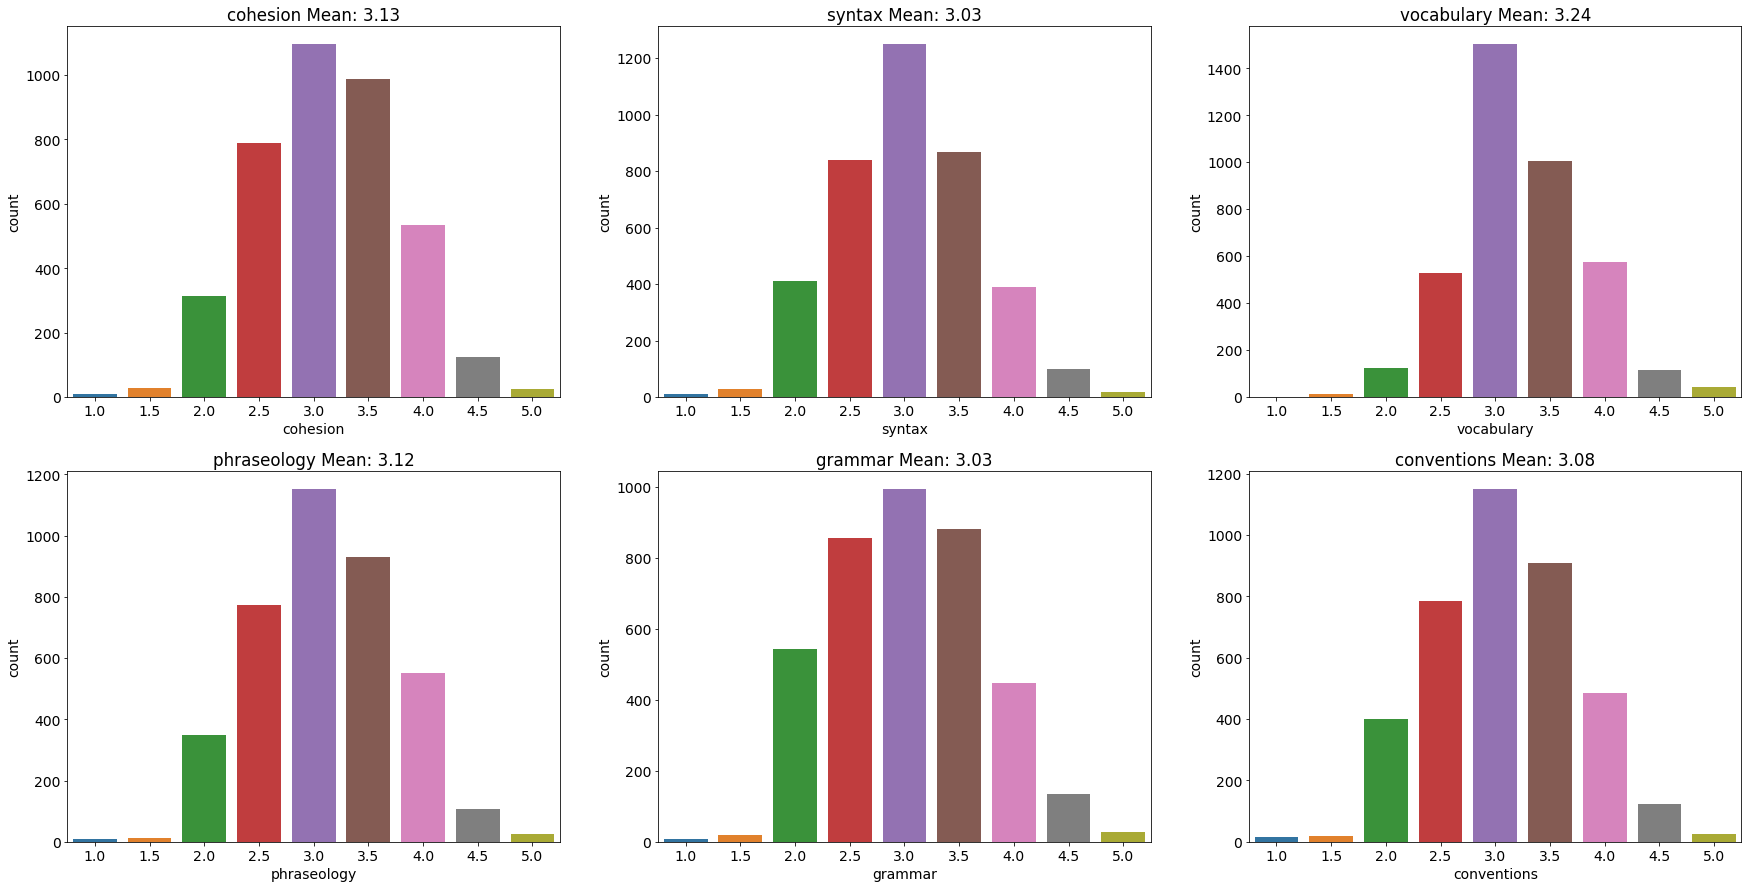

In [19]:
target_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
f, axarr = plt.subplots(2, 3, figsize=(30, 15))
for idx, col in enumerate(target_cols):
    ax = axarr.flat[idx]
    sns.countplot(x=df[col], ax=ax)
    ax.set_title(f"{col} Mean: {df[col].mean():.2f}")
plt.show()

In [67]:
# The scores all correlate highly positive (0.64 - 0.73). I would guess that the same person gives all these ratings for one essay and the complicated individual question of "How good is the phraseology of this essay"
# is substituted with "How is the overall quality of the essay + are there any large reasons, I should give a different phraseology rating?", which makes the scores more correlated than they should be.
df[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].corr()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
cohesion,1.000000,0.695459,0.666151,0.690058,0.638689,0.666151
syntax,0.695459,1.000000,0.680562,0.725467,0.709525,0.700025
vocabulary,0.666151,0.680562,1.000000,0.735261,0.654852,0.664292
phraseology,0.690058,0.725467,0.735261,1.000000,0.719746,0.666842
grammar,0.638689,0.709525,0.654852,0.719746,1.000000,0.673301
conventions,0.666151,0.700025,0.664292,0.666842,0.673301,1.000000


In [27]:
df["total_score"] = df[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].sum(axis=1)
df["std_score"] = df[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].std(axis=1)

In [26]:
# Look at some essays with very low scores
print(df[df["total_score"] <= 10].shape)
df[df["total_score"] <= 10].sample(2)

(28, 9)


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,total_score
3406,EA04020F5ECD,"when people ask you for advice they sometimes talk to more people than one they ask they ask for a good advice becuase if they will not have good advice they can't think about a good decision somtimes a person who have trouble in her or his life or any depression our any happiness in thier life they can't make control thier a control on them. so they get pannic sometimes they can't think what to do they don't know how to do things so that's why they from many people but when they seeks multiple opinions so they get confiused they can't select one opinion that is good for them they want to think about that but they can't do that so they ask many people for different opinions so that's good but also not good tho but so they need to figure that what they should do or what not what i think is it's ok to ask people thier opinions but we should also need to think use our mind whithout our mind we can not do any thing the opinions that are given by other people we should think about them like what are they saying what's the point is it good for us or not or if i will follow this opinion it will make trouble for me or not then u will ask your friend or a person that is so close to you if that person will say yes you will be like ok than . lets do it!\n\nso you do a whole long procisior for getting a one good opinion what you need to do is that ask opinions from two or three people and then if u think it's not a good opinion than think your own and then take a good decission. everyone takes thier own decission i think if you wanna ask for a opinion find a good trustful adult who really really wants to help you who will give you a better choice and then think about it if you think that she or he is right then just follow the directions for example i have a birthday party and i need to select the dresses for everyone and arrange the birthday party and i don't have enough time i am so worried and confiused i don't known what to do .\n\ni need a help from people i asked from my friends, cousins ,family, teachers and then i think that i have a lot of opinions so i can't choose\n\n1 so what i did was i asked my older cousine and then we discused about that she told me in details what to do and then i managed my time and i choosed the dresses i arranged the birthday party in one week everything was so good that's how we make better chioce for our self if u can't do that at least think on your own or ask for help and ask from a good person not anyone you don't know well becuase people can play with you so we have to be carefull so i think asking an adult is more better than asking a lot of people becuase asking an adult will help you more becuase the first time i need help and i asked a lot of people and i was so confiused and i was like what is going on with me because it was my first excperience i didn't use my mind it was so bad waste of time every thing was ruined and that's why i learned something is never do anything that your parents or adult don't like here is another way to make a better choice and that is always listen to your parents and your adult because sometimes the decisions that you are making it seems like they are good but after some time you realize that it's not good for you u get in trouble and all you have face somethings so thats why do what your parents are telling you to do not what you wants to do it's ok to listen to your heart but sometimes it's not so the best way to make a better choice is listen your parents and adult\n\n2nd is use your mind to think that it's good or bad the 3rd way is to ask someone who is an adult and such a nice and truthfull person believe in your self and your god these are the best ways to make a better choice we should always believe in your self and your parents because they will always tell you a thing that is good for you no matter what it is just think that yuor parents tell y

In [37]:
# Look at some essays with very high scores
print(df[df["total_score"] >= 26].shape)
df[df["total_score"] >= 26].sample(2)

(109, 10)


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,total_score,std_score
1156,597D76A3BF40,"I would like to start of this topic with a important question that no human being really thinks about, ""How is technology impacting our health?"" That is one of the most important questions that we can't leave unanswered.\n\nThe use of technology have rooted in our lives, from the moment we wake up till the moment we go to bed we have hundreds of interaction with various devices, software programs, and tools. Technology allows people to complete many tasks without having any contact with others. People can check out books, shop, and play games without speaking to any other person. The limitation of human contact due to the use of technology had negative effects on people's lives.\n\nWhile one might think that the limitation of human contact due to the use of technology had positive effects on people's lives, others might think that the lack of human contact due to the use of technology had negative effects on people's lives which most people agree with.\n\nWhen comparing two human beings, one human being that always uses technology to do everything, shop, check out books, play games, do homework, and even talk to friends or family members, that person is most likely going to get sick, be in a lot of pain, or even feel depressed sooner then the person that prefers not to use technology at all but instead of using technology they would rather go out to the store to buy a book, go out to the store to shop new clothes, and even instead of calling on the phone to check on a family member they would rather go out and see them in real life. The reason the person that uses technology more is more likely to get sick or be in pain sooner than the other one is because not only computers and devices encourage more sedentary behavior among users but they also frequently lead to poor posture, neck stain, back issues, and hearing loss. This sort of behavior can lead to chronic pain and discomfort that is hard and not really easy to treat.\n\nNow that we have explained and understood this topic a little bit better let's go back to the question that we asked at the beginning, in case some of you guys forgot the question, the question was\n\n""How is technology impacting our health?"" If people really took the time to think about this question that we usually always leave unanswered we would have known that technology isn't impacting our health in any positive way, technology actually makes us stressed, makes our eye vision bad, gives us back pain, hearing loss, and a lot of other negative outcomes. Another reason why people might feel depressed when they use technology a lot, is because they don't really interact with people and dont have any friends since all they do is stay at home and do everything on their device. It's scientifically proved that every human being need at least one or more friends to talk to every time they feel down and don't feel really good about something. That is the reason why most of the people that use technology a lot, sometimes feel depressed and don't really like to interact with other people around them.\n\nIn conclusion , technology allows people to complete many tasks without having contact with others and the limitation of human contact due to the use of technology had a negative effect on people's life and if people don't learn how to control and manage their time and not use technology every chance they get, our next generation will be exactly the same as this one right now .The sad thing about the limitation of human contact due the use of technology is that there is no turning back at this point we are in a society where technological innovation and progression is the norm; It would take a minor miracle to reverse all this disaster. In order for all of this mess to get better,\n\npeople need to start learning about how to balance their time even if they're using technology, otherwise it 

In [36]:
# Look at some essays with very different scores over the 6 dimensions
print(df[df["std_score"] >= 0.65].shape)
df[df["std_score"] >= 0.65].sample(2)

(15, 10)


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,total_score,std_score
1947,92F7DD653EFB,"Some people think that is more beneficial working alone that working in group. Which I disagree with for two reasons: People always need help and is more beneficial working in group. I feel that the benefits come from others.\n\nThe first reason is that we as a human being, we need help. When we are working, we need help from others at work, during class at school, anywhere where we work. For example, at work when I'm cooking I also need someone that can brings the ingredients. Some would argue that, working in group don't help you to learn, but we learn from others not from ourselves. As a result, we obtain help from others working as a group. Additionally, we obtain benefits working in groups. In addition, benefits to us are made it from others, benefits to others are made it from us. To illustrate, when I'm sick, and I can't go to work I need someone to change his scheduled, and take my place, for that day, so he is going to need the same benefit from me to cover him one day he get be sick, or will have any emergency. Some may say that working in group is not beneficial, working in a group we acquired more benefits than working alone. As a result working in groups give us the chance to have more benefits.\n\nIt's obvious that, working is groups is more beneficial this will allow us to get the help need it from others, and to have more benefits made it by others. We should always work in groups, helping each other as a human being.",4.0,3.0,3.5,2.0,3.0,3.0,18.5,0.66458
3457,ECC9E84CD3D1,"I think that students should start an after school homework club. 3 reasons I think that students should start this club is so that they'll have an easier time doing their assignments that their teachers give them, they can work together to get their homework done, and students can work with their teachers to raise their grades up in a specific subject.\n\nMy first reason is that students can have a easier time doing their assignments that their teachers give them. My 3 reasons that students can have a easier time doing their assignments is that the students can ask their teachers for assistance if they need it, they'll get their work done quicker, and when their teachers come to collect their work, the students will have it already completed.\n\nMy second reason is that the students can work together to get their homework done. My 3 reasons that students should work together to get their homework done is so that they can turn it into their teacher once they're done, they'll have it all completed when their teacher asks the students to give their homework up, and they'll receive a good grade from their teacher.\n\nMy third reason is that students can work with their teacher to raise their grades up in a specific subject. My 3 reasons that students should work with their teachers to raise their grade up in a specific subject is so that they can be more productive in class, they can catch up on what they've missed in class, and the teacher can guide the students on what they're confused on on their homework.\n\nOverall, these are my reasons why I think that students should have the opportunity to have an after school homework club.",3.0,3.0,3.0,2.0,4.0,3.5,18.5,0.66458


In [38]:
print(test.shape)
test.sample(2)

(3, 2)


,text_id,full_text
0,0000C359D63E,"when a person has no experience on a job their is always going to be good people to help you and try to explane the job you need to get done in life you were not born with knowing everything. Life is bassicly about learing new things every single day even though without experience because life is simple and we must live happy and around with the people we love. When a person thinks they know everything in life they dont do good because they trying to make the other person less then others you must be kind to those the dont have experience because you may not know some day you will go to a different country. When you dont know anyting because you not from their so you going to need help from others to explain you about the culture or how to eat a food because you have to no experience on the new country. You must help a person the has no experience because maybe you may need help from the person the you didnt want to help.\n\nyes, even thought you may not have experience in the type of job you seek,you can learn and teach others.\n\nIf you dont have experence in a restaurant for the job you seek for you will learn. For example a person the has no experence working in a restaurant,the only place they will offer you would be to be a diswasher. But you want to dream big because everytime a person has big dreams they can learn the job whereever, you want to be like a cooking person or a kitchen manager. In a job there is always going to be people the they dont want to see you in a better place because they may think you dont deserve to be there but you the only one the knows how hard you being working to achieve your dream .In life you always going to have proof without experience to see how good you are to learn a new job in the kitchen so if you can learn quick. They can give you a good place for you teach others the has no experience.\n\nMy dad has always talk with my cousins that when their is no experience you can always learn and fight for what you want. When my cosuin came to America he wanted to play travel soccer, he went to tryout but the coach told him the has any experience of talking english so he wouldn't make it. But later on he learn how to speak then, he went to tryout for fc virginia he made it also everyone was talking about him because hes a great soccer player also, hes a great person. Then he came to the house and thanks my dad because of the edvice he gave to him the even though you dont have experience,you can always learn and fight for you goals. My dad is man the wants the best for hes family because when he was a kid he wanted to be a loyer but it was hard for hes parents because they were really poor and the corruption was really bad in the country.\n\nIn every job their is always going to be a person with no experience. For example people with no experience those are the ones the learn the job and when they learn the job very well they always try not to make a mistake because thay want to get the job done with quality. Because everytime you do a job for someone else they want to see good quality on you before they give the kind of job they want you to get done for them. The people the has no experience in a job that doesnt make them a less person because we all are humans and we must have the same equal rights. we all know the everytime you aplied for a job the first thing they asked you is about if you have experience but its okay to say no because they can teach you and you can get it fast.\n\nI think yes, you can be a good candidate to be hire without no experience because every person in the world needs to have a opportunity to try something new. People today in life they dont need to have experience to go find a job why because today in every work you get one week of train which people can learn the job just in one week. Because they will practice the job and every time they get practice they will going to get better and better. Practices makes everything better s

In [39]:
print(submission.shape)
submission.sample(2)

(3, 7)


,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0


# Compare labels with external tools (Quillbot, Grammarly)

To understand the objectivity of our labels, let's do an experiment and compare a random sample of our labels with the scores from https://quillbot.com/grammar-check and grammarly.com
- Quillbot (error rate and readability level)
- Grammarly (error rate, overall score, readability score, unique words %, rare words %)

- A blog post I put in there as a test, got a Quill 2% error rate, a readability of 10-12 grade and a Grammarly 0% error rate, 83 Score, 70 readability, 33% unique, 22% rare words

In [20]:
for col in ["quill_error_rate", "quill_readability", "grammarly_error_rate", "grammarly_score", "grammarly_readability", "grammarly_unique_perc", "grammarly_rare_perc"]:
    df[col] = np.nan

In [21]:
idx = 3689
df.loc[idx, "quill_error_rate"] = 13
df.loc[idx, "quill_readability"] = 2 #"College"
df.loc[idx, "grammarly_error_rate"] = 73/751 * 100
df.loc[idx, "grammarly_score"] = 24
df.loc[idx, "grammarly_readability"] = 45
df.loc[idx, "grammarly_unique_perc"] = 22
df.loc[idx, "grammarly_rare_perc"] = 15

idx = 1131
df.loc[idx, "quill_error_rate"] = 7
df.loc[idx, "quill_readability"] = 2 #"College"
df.loc[idx, "grammarly_error_rate"] = 28/657 * 100
df.loc[idx, "grammarly_score"] = 50
df.loc[idx, "grammarly_readability"] = 50
df.loc[idx, "grammarly_unique_perc"] = 34
df.loc[idx, "grammarly_rare_perc"] = 23

idx = 2072
df.loc[idx, "quill_error_rate"] = 8
df.loc[idx, "quill_readability"] = 1 #"Professional"
df.loc[idx, "grammarly_error_rate"] = 25/602 * 100
df.loc[idx, "grammarly_score"] = 55
df.loc[idx, "grammarly_readability"] = 12
df.loc[idx, "grammarly_unique_perc"] = 33
df.loc[idx, "grammarly_rare_perc"] = 17

idx = 1195   
df.loc[idx, "quill_error_rate"] = 17
df.loc[idx, "quill_readability"] = 3 #"10-12 grade"
df.loc[idx, "grammarly_error_rate"] = 47/295 * 100
df.loc[idx, "grammarly_score"] = 13
df.loc[idx, "grammarly_readability"] = 63
df.loc[idx, "grammarly_unique_perc"] = 40
df.loc[idx, "grammarly_rare_perc"] = 18

idx = 3868
df.loc[idx, "quill_error_rate"] = 12
df.loc[idx, "quill_readability"] = 1 #"Professional"
df.loc[idx, "grammarly_error_rate"] = 28/195 * 100
df.loc[idx, "grammarly_score"] = 27
df.loc[idx, "grammarly_readability"] = 29
df.loc[idx, "grammarly_unique_perc"] = 39
df.loc[idx, "grammarly_rare_perc"] = 6

idx = 2815
df.loc[idx, "quill_error_rate"] = 16
df.loc[idx, "quill_readability"] = 2 #"College"
df.loc[idx, "grammarly_error_rate"] = 82/473 * 100
df.loc[idx, "grammarly_score"] = 11
df.loc[idx, "grammarly_readability"] = 56
df.loc[idx, "grammarly_unique_perc"] = 38
df.loc[idx, "grammarly_rare_perc"] = 22

idx = 1700
df.loc[idx, "quill_error_rate"] = 8
df.loc[idx, "quill_readability"] = 4 #"8th-9th grade"
df.loc[idx, "grammarly_error_rate"] = 28/396 * 100
df.loc[idx, "grammarly_score"] = 32
df.loc[idx, "grammarly_readability"] = 76
df.loc[idx, "grammarly_unique_perc"] = 41
df.loc[idx, "grammarly_rare_perc"] = 25

In [22]:
df[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions', 
    "quill_error_rate", "quill_readability", "grammarly_error_rate", "grammarly_score", "grammarly_readability", "grammarly_unique_perc", "grammarly_rare_perc"]].corr()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,quill_error_rate,quill_readability,grammarly_error_rate,grammarly_score,grammarly_readability,grammarly_unique_perc,grammarly_rare_perc
cohesion,1.000000,0.695459,0.666151,0.690058,0.638689,0.666151,-0.055189,0.750000,-0.026206,-0.227342,0.877632,0.125321,0.635634
syntax,0.695459,1.000000,0.680562,0.725467,0.709525,0.700025,-0.452414,0.597739,-0.377150,0.226223,0.632291,0.263773,0.601228
vocabulary,0.666151,0.680562,1.000000,0.735261,0.654852,0.664292,-0.379864,0.504125,-0.394534,0.221886,0.584029,0.049176,0.828210
phraseology,0.690058,0.725467,0.735261,1.000000,0.719746,0.666842,-0.472195,0.559793,-0.456349,0.356821,0.525503,0.366436,0.760626
grammar,0.638689,0.709525,0.654852,0.719746,1.000000,0.673301,-0.518688,0.652668,-0.481805,0.263612,0.610942,0.104398,0.518829
conventions,0.666151,0.700025,0.664292,0.666842,0.673301,1.000000,-0.217397,0.740593,-0.213358,-0.047977,0.782115,0.058575,0.516744
quill_error_rate,-0.055189,-0.452414,-0.379864,-0.472195,-0.518688,-0.217397,1.000000,0.055189,0.926239,-0.911721,0.239393,0.087033,-0.233146
quill_readability,0.750000,0.597739,0.504125,0.559793,0.652668,0.740593,0.055189,1.000000,0.032697,-0.324587,0.924536,0.348866,0.660081
grammarly_error_rate,-0.026206,-0.377150,-0.394534,-0.456349,-0.481805,-0.213358,0.926239,0.032697,1.000000,-0.925504,0.261142,0.329796,-0.310149
grammarly_score,-0.227342,0.226223,0.221886,0.356821,0.263612,-0.047977,-0.911721,-0.324587,-0.925504,1.000000,-0.522162,-0.201255,0.103320


The dataset is a collection of 3911 argumentative essays of 8th-12th grade English Language Lerners. The essays have been scored according to six analytic measures: cohesion, syntax, vocabulary, phraseology, grammar and conventions. The scores range from 1.0-5.0 in increments of 0.5, higher is better. (https://www.kaggle.com/competitions/feedback-prize-english-language-learning/data)
 
 - cohesion = the way we use vocabulary and grammatical structures to make connections between the ideas within a text
 - syntax = the set of rules that determine the arrangement of words in a sentence
 - vocabulary = the words you can easily summon and use
 - phraseology = organizing words and phrases into longer elements
 - grammar = rules and conventions that govern how words can be put together to make meaning
 - conventions = the mechanics of writing, like capitals, punctuation and handwriting

What are some interesting patterns here within the two different external sources:
- very high positive correlation of 0.92 for the readability scores of Quill and Grammarly. This makes sense, because both use a slightly different coding based on the [Flesch reading ease score](https://readable.com/readability/flesch-reading-ease-flesch-kincaid-grade-level/#:~:text=The%20Flesch%20Reading%20Ease%20gives,the%201940s%20by%20Rudolf%20Flesch.) = The score gets lower the more words an average sentence has and the longer an average word is.
- very high positive correlation of 0.93 for the error rates of Quill and Grammarly. Both count all grammar/spelling/capitalization/punctuation/... mistakes together.

How do the labels correlate with the external sources?
- Cohesion correlates strongly (0.88) with the flesch reading ease score (grammarly readability score). It is not measuring the same, but it makes sense that better connected essays do that with less words per sentence and shorter words.
- Syntax also correlates positively (0.63) with the reading ease score and has negative correlation with both error rates (~ -0.4). Good syntax correlates with less errors.
- Vocabulary correlates strongly (0.83) with the percentage of rare words (% of words that are not in the top 5000 of commonly used english words). This makes sense and because of the high correlation, looking this statistic up could be used as a proxy for the vocabulary score!
- Phraseology also correlates highly positive (0.76) with the percentage of rare words and has negative correlation with both error rates (~ -0.46). Good phraseology correlates with less errors. Also, of all dimenstions it has the highest correlation (0.36) with the overall Grammarly score.
- Grammar has the highest negative correlation with both error rates (~ -0.5). This makes sense as grammar mistakes are included in the error rates.
- Conventions has a high positive correlation (0.78) with the reading ease score. The shorter your words and sentences, the easier it is to have less conventions errors.

Next Steps
- A useful baseline for Vocabulary could be to look at the percentage of rare words
- The Flesch reading ease score could be a good baseline for a lot of dimensions, especially cohesion and conventions

In [19]:
df = pd.read_pickle("data/trainval_splits_2022_10_20.pkl")
for idx, row in df.sample(7, random_state=13322).iterrows():
    print(row[['cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions']])
    print(idx, len(row["full_text"].split(" ")), row["full_text"])
    print("#"*100)

cohesion       3.5
syntax         2.5
vocabulary     3.0
phraseology    2.5
grammar        3.0
conventions    3.5
Name: 3689, dtype: object
3689 751 In some occasion you feel weary or oppress to think about that you have to take high school during 4-years when you know that you can do in 3-years? Some school districts are thinking is this wonderful ides to offer a programs to the students that they can graduate in 3-years, the school districts should be approve the idea to graduate in 3-years because it will be so helpful to the students to feel more motivate to graduate early, the students will use the other year to work and make money to pay some par of their career, and the students can enter and start college one year early .

The students will feel more motivate to graduate early becasue many students that come from middle school they really took class of high school like Algebra 1, Geometry, Earth Science, History 1 ect, they can easely graduate and 3-years. I have two brothers o

# Baselines to try before modeling

## The Flesch Reading Ease score
![flesch_reading_ease](flesch_reading_ease.png)

In [127]:
# !pip install syllables # https://github.com/prosegrinder/python-syllables
import syllables
from nltk.tokenize import word_tokenize

In [128]:
def flesch_reading_ease_score(text):
    total_sentences = len(text.split("."))
    tokens = word_tokenize(text)
    total_words = len(tokens)
    total_syllables = sum([syllables.estimate(token) for token in tokens])
    score = 206.835 - 1.015 * (total_words / total_sentences) - 84.6 * (total_syllables / total_words)
#     print(f"{total_sentences:3} sentences with {total_words:4} words and {total_syllables:4} syllables --> Score: {score:.3f}")
    return score

df["flesch_reading_ease_score"] = df["full_text"].apply(lambda x: flesch_reading_ease_score(x))

<AxesSubplot:>

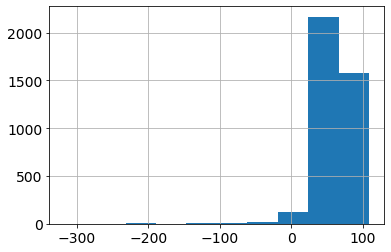

In [129]:
df["flesch_reading_ease_score"].hist()

In [130]:
df.loc[df["flesch_reading_ease_score"] < -10, "full_text"].sample(1)

1471    I agree with this prompt many cases it is impossible say the people but i will tell you something we can, many peoples says is impossible to change the world, and you know what we can is something is on our head that keeps blocking, i think it is our priority number one, change the world, change our vision of watch our environment,\n\nthe people needs to change to see the real thing that is happening on our environment, change one little thing is a big change does not matter what but the change began, i would say among the world and our life, do you think our life are safe i say no because the global warning it is on us, and we can change it of course, the thing is nobody it is gonna get up until someone do, what we have been doing is not wright, the change is coming. We have been doing a lot of work every day and you know what for global warning, know let's talk about the people many peoples say can't change them self because is hard, it is impossible, no one will see change o

In [131]:
df.loc[df["flesch_reading_ease_score"] > 90, "full_text"].sample(1)

757    Should your school extend the school day for two hours or they should not extend the school day for two hours? If your school extend school day for two hours there are some thing you can't do. You can't play after school games. You can't do your homework. You have less time to work. You going home late. You can't fresh your mind.\n\nReason one, students who work after school they have moer time on work. For example, if your working time is four o'clock to ten o'clock. If you work regular time you going to make more money. Students need to work becaus they needs to pay the cell phome bills or on gasolin.\n\nReason two, students who want to play after school game they can play the game. If they don't have time to play after school game they can't fresh there mind. For example, students who live one or two hours away for school they have time to play after school game.\n\nReason three, students can fresh there mind. Students can't fresh there mind because they are studying more the

In [120]:
df[["flesch_reading_ease_score", 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].corr()

,flesch_reading_ease_score,cohesion,syntax,vocabulary,phraseology,grammar,conventions
flesch_reading_ease_score,1.000000,0.115096,0.189470,0.071507,0.096220,0.139902,0.169434
cohesion,0.115096,1.000000,0.695459,0.666151,0.690058,0.638689,0.666151
syntax,0.189470,0.695459,1.000000,0.680562,0.725467,0.709525,0.700025
vocabulary,0.071507,0.666151,0.680562,1.000000,0.735261,0.654852,0.664292
phraseology,0.096220,0.690058,0.725467,0.735261,1.000000,0.719746,0.666842
grammar,0.139902,0.638689,0.709525,0.654852,0.719746,1.000000,0.673301
conventions,0.169434,0.666151,0.700025,0.664292,0.666842,0.673301,1.000000


Why are the correlations so low now? Are the flesch reading ease scores different between grammarly and our own implementation?

In [124]:
df.loc[df["quill_error_rate"].notnull(), ["full_text", "quill_readability", "grammarly_readability", "flesch_reading_ease_score"]]

,full_text,quill_readability,grammarly_readability,flesch_reading_ease_score
1131,"Ever since I was in elementary school I have had an interest in your company. Technology was not as big as it is today, but for some reason I have always shown interest in the products that your company has made. When you created the windows PC it revolutionized the world of technology, and ever since then I have been taking technology classes, programming classes, and even engineering classes so that one day I can created something of my own or even be a part of something surrounding your companies work. It would mean a lot if you gave me the chance to come visit your company and learn about the things your company does such as, what type of work your employees do throughout the week, the environment among and which your employees work in, and how you maintain your servers for your computers across the world I would also like to learn a little bit more of your journey as an entrepreneur in your early days, the sacrifices you had to make and the chances you took to get where you are today.\n\nI am the perfect candidate to be picked as an intern for your company because of the fact that i have dedicated my life to technology and even followed your footsteps. I know everything there is to know about computer science, programming, and engineering. Out of all the companies that deal with computers, yours is by far the best. I have researched everything about your company going back to the roots when you were in the garage building your computer and programming them to now being one of the richest men in the world having your employees build them for you. I aspire to become a great man like you and this the perfect opportunity to show you and everyone else what i am capable of. I believe that if you choose me as your intern you will gain an even greater advantage in the world of business and technology, I have a certain set of skills that allow me to learn things quick about human behavior and gain the advantage over competing companies i have studied the nature of consumers and i know exactly what they like to see and hear, having me learn a thing or two from you will give not only me a learning experience but you as well.\n\nGiving me the chance to see your company work in person is one of my life goals and it would be an honor to learn how you managed to become not only one of the richest men in the world but also learn what made you decide to take on a challenge such as technology giving that it was one of the hardest things to adapt to in your time. You managed on your own to create something as big as your company with just an idea and some programs. Learning something from you is a once in a lifetime thing that probably never happens to most up and coming entrepreneurs like me. Giving me this chance not only helps me but it helps my family and my community. we live in a small town with not much technology and my dream is to change that I want the people in my town to experience the wonders of technology i want to show them that i learned everything I know from the man who started it all, the man who revolutionized the world.\n\nIn conclusion, giving me the chance to see the work you have created will spark something new in this world of technology. I have followed your footsteps, i have dedicated my life to technology and engineering. However with this opportunity i will create something of my own for my home town so that all my family members and towns people can experience the joys of technology.",2.0,50.0,45.729272
1195,"It has been said that a positive attitude is the key to success in life. I agree with statement because having a positive attitude led to great success and great oppurtunity to do something that you would love, or admire.\n\nWith a positive attitude you could do more in life than a person with a bad attitude. For example, a person with a bad attitude trying to get a job as a model but gets mad over how the clothes looks on 

In [134]:
df[["quill_readability", "grammarly_readability", "flesch_reading_ease_score"]].corr()

,quill_readability,grammarly_readability,flesch_reading_ease_score
quill_readability,1.000000,0.924536,0.875638
grammarly_readability,0.924536,1.000000,0.966570
flesch_reading_ease_score,0.875638,0.966570,1.000000


Not really, they match up quite well. Then, our small random sample of 7 essays and their external scores gave us a wrong impression of the usefulness of the flesch reading ease score.

## Ideas for the vocabulary score

In [78]:
stop_words = set(stopwords.words('english'))
df["tokenized_clean_text"] = df["full_text"].apply(lambda x: [w for w in word_tokenize(x) if not w.lower() in stop_words])

### % of tokens from the top 5000 most common english words
- Does not work that great, because misspellings are misinterpreted as rare words

In [79]:
from nltk import FreqDist
from nltk.corpus import brown
from nltk.tokenize import word_tokenize

In [80]:
frequency_list = FreqDist(i.lower() for i in brown.words())
most_common_5000_words = [k for k,v in frequency_list.most_common()[:5000]]
most_common_5000_words[:9]

['the', ',', '.', 'of', 'and', 'to', 'a', 'in', 'that']

In [92]:
def top5000_perc(text):
    filtered_text = [w.lower() for w in word_tokenize(text) if not w.lower() in stop_words]
    return sum([1 for k in filtered_text if k in most_common_5000_words]) / len(filtered_text)

df["rare_words"] = df["tokenized_clean_text"].apply(lambda x: sum([1 for k in x if k not in most_common_5000_words]))
# df["top5000_perc"] = df["tokenized_clean_text"].apply(lambda x: sum([1 for k in x if k in most_common_5000_words]) / len(x))

<AxesSubplot:>

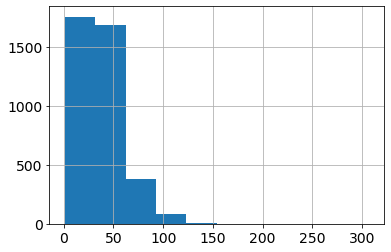

In [93]:
df["rare_words"].hist()

In [97]:
df.loc[df["rare_words"] < 3, "full_text"].sample(1)

2501    The principal is considering changing school policy and she have what the students is good and the principal where the students change possible policy. Be sure to support and specific reasons . many students have a grade C average and least a grade B average to principal in sports or other activities. she would to hear the students views on this possible policy change. and the principal can do in participate in the students to policy change.
Name: full_text, dtype: object

In [98]:
df.loc[df["rare_words"] > 150, "full_text"].sample(1)

375    I`m agree whit the individuality. I like when the people take whatever they wants for yours life is so cool. I have too much friend and they do the think another peoples do. I mean i like do what i`m said and what i like i don`t now.\n\nMy family is so negative when they said sometime and i don`t like because i want said sometime but they no want lisent. so i`m individuality because i want lisent to me and do the think i want.\n\nI know to much people dependt of other and that`s no good.\n\nThe history class said too much about that because in the past the people are not indiviuality.\n\nI think the people want more attention that why depent of other people.\n\nThe life now is to diferent of after because now the people yos depent the what said other person about who i`m look or what he said about me an all theese think.\n\nI like who i am cause i`m a nice and all good thinks so i do whathever i wnat because i ike who is the people and i dont care what they said about me.\n\nYo 

<AxesSubplot:>

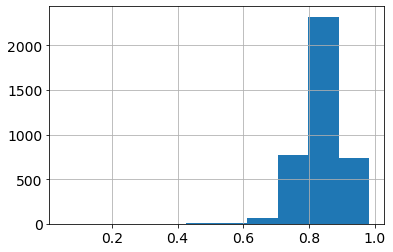

In [82]:
df["top5000_perc"].hist()

In [83]:
df.loc[df["top5000_perc"] < 0.6, "full_text"].sample(1)

1600    "Unles you try to do somthing beyond what you have already mastered you will never grow".\n\nYes you will never grow becuase you will never have now experience, that will need in the feater I agree with author Ralpn Emerson for three reasons. First, whan you try a now things you are going to have different naleg about a laset of different thing . Sconed , whan you have different ideas you have different way of thinking. Thired , whan you try to see other people and how they act and thiar coolter you will now how to talk with thim without disrspact thim . Lastly, that why we sholed alwase laren.\n\nWhan I try a now things i alwas laren some thing now .\n\nFor exampe, whaen i came to the U.S i did not have enafe naleg about what is in the U.S so that was a issue ror me learening the language i shragl becuase did not go beyond what i have already mastred. Than ,whan i staret to learen more about the language i start to go beyond my noleg. Allthuo life is hared and learening is har

In [84]:
df.loc[df["top5000_perc"] > 0.95, "full_text"].sample(1)

2030    The benefits of having a good attitude\n\nThere are a lot of benefits because of having good attitudes, we can get more time to make again what we were doing and do not stop until we make it the best we could.\n\nIn other way, been with a good attitude can help us improve in life that helps us to learn, to concentrate and, to be a good thinking of someone else.\n\nAlso, something kind of the same happened to me some time ago when my father was teaching me how to drive, and every time I did something wrong he yelled at me and one day I was with a really bad attitude because of that and than I realized that been mad was not going to help me so i changed my attitude and i learn to drive really fast.\n\nBeen mad only makes us worst at doing that because we are not thinking about the positive thinks of that activity just at the negative thinks and thats what makes everything worst.\n\nThe benefits of having good attitude its that it can help us to try again something we miss, been f

In [94]:
df[["rare_words", "top5000_perc", 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].corr()

,rare_words,top5000_perc,cohesion,syntax,vocabulary,phraseology,grammar,conventions
rare_words,1.000000,-0.567332,0.128430,0.126100,0.197287,0.134230,0.061858,0.029612
top5000_perc,-0.567332,1.000000,0.151067,0.119875,0.104887,0.119725,0.085291,0.225025
cohesion,0.128430,0.151067,1.000000,0.695459,0.666151,0.690058,0.638689,0.666151
syntax,0.126100,0.119875,0.695459,1.000000,0.680562,0.725467,0.709525,0.700025
vocabulary,0.197287,0.104887,0.666151,0.680562,1.000000,0.735261,0.654852,0.664292
phraseology,0.134230,0.119725,0.690058,0.725467,0.735261,1.000000,0.719746,0.666842
grammar,0.061858,0.085291,0.638689,0.709525,0.654852,0.719746,1.000000,0.673301
conventions,0.029612,0.225025,0.666151,0.700025,0.664292,0.666842,0.673301,1.000000


The problem is that wrongly spelled words or words in other languages get counted as rare. We would need to remove all spelling errors before being able to use this metric.

### Number of unique words
Has a significant positive correlation (0.39) with Vocabulary.

In [86]:
df["unique_words"] = df["tokenized_clean_text"].apply(lambda x: len(set(x)))

<AxesSubplot:>

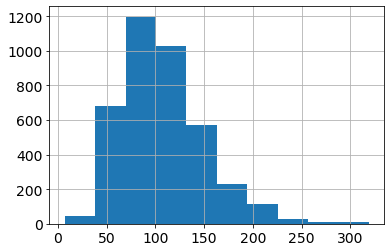

In [87]:
df["unique_words"].hist()

In [88]:
df.loc[df["unique_words"] < 10, "full_text"].sample(1)

3679    the memorable teacher ever had\r\n\r\nwas a teacher in 10\r\n\r\nword\r\n\r\nwild all students
Name: full_text, dtype: object

In [89]:
df.loc[df["unique_words"] > 250, "full_text"].sample(1)

3652    Is a positive attitude key to success? Well, In my opinion I strongly agree, I believe a positive attitude will take you far in life and will let you accomplish many goals you've set for yourself. For instance having a positive attitude doesnt just affect you but it also affects others in a negative or positive way, for example motivation; you could motivate someone and inspire them just by doing you and accomplishing youre goals or you could even brighten somebodies day up by doing small gestures. In the other hand there will be people that dont want too see you do good, people that want to bring you down and people that have envy over you. That shouldn't bring you down that should be more motivation to do better because those are people who are jealous, people that are jealous of something you have and that they dont have. There are people who have started from the bottom with very little and are now doing big things, by having a positive mind set and believing in themselves.

In [90]:
df[["unique_words", 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].corr()

,unique_words,cohesion,syntax,vocabulary,phraseology,grammar,conventions
unique_words,1.000000,0.306629,0.277747,0.390934,0.331119,0.190376,0.203403
cohesion,0.306629,1.000000,0.695459,0.666151,0.690058,0.638689,0.666151
syntax,0.277747,0.695459,1.000000,0.680562,0.725467,0.709525,0.700025
vocabulary,0.390934,0.666151,0.680562,1.000000,0.735261,0.654852,0.664292
phraseology,0.331119,0.690058,0.725467,0.735261,1.000000,0.719746,0.666842
grammar,0.190376,0.638689,0.709525,0.654852,0.719746,1.000000,0.673301
conventions,0.203403,0.666151,0.700025,0.664292,0.666842,0.673301,1.000000


# Train

## Create train/val splits

In [4]:
n_fold = 3
seed = 1336

Fold = MultilabelStratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
for n, (train_index, val_index) in enumerate(Fold.split(df, df[target_cols])):
    df.loc[val_index, 'fold'] = int(n)
df['fold'] = df['fold'].astype(int)
display(df.groupby('fold').size())

fold
0    1304
1    1303
2    1304
dtype: int64

In [73]:
df.to_pickle("data/trainval_splits_2022_10_20.pkl")

## Find max length for model

In [5]:
backbone = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(backbone)
tokenizer.save_pretrained('tokenizer/')

# ====================================================
# Define max_len
# ====================================================
lengths = []
tk0 = df['full_text'].fillna("").values
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
max_length = 1100 #max(lengths) + 3
print(f"max_len: {max_length}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


max_len: 1100


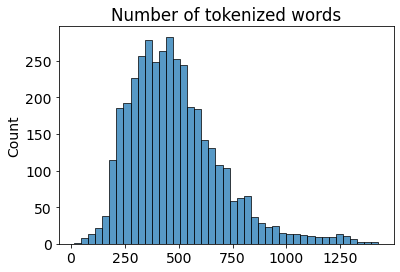

In [6]:
sns.histplot(lengths)
plt.title("Number of tokenized words")
plt.show()

## Train

In [7]:
# # import shutil
# shutil.rmtree("trained_models/Exp1/fold2/p1")

In [8]:
class TrainGlobalConfig:
    exp_name = "Exp2"
    num_workers = 8
    batch_size = 8
    n_epochs = 5000
    lr = 2e-5
    fp16 = True

    # -------------------
    verbose = True
    verbose_step = 500
    # -------------------

    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    
    early_stopping_patience = 9
    # -------------------
    criterion = nn.SmoothL1Loss(reduction='mean') #nn.BCEWithLogitsLoss()

In [ ]:
for fold_nb in range(3):
    df_train = df[df["fold"] != fold_nb]#.iloc[:200].copy()
    df_val = df[df["fold"] == fold_nb]#.iloc[:100].copy()
    
    train_dataset = FeedbackDataset(
        targets=df_train[target_cols].values, 
        texts=df_train['full_text'].values,
        tokenizer=tokenizer,
        max_length=max_length,
#         dataset_length_multiplier=10
    )
    val_dataset = FeedbackDataset(
        targets=df_val[target_cols].values, 
        texts=df_val['full_text'].values, 
        tokenizer=tokenizer,
        max_length=max_length
    )
    print(f"Trainset has {len(train_dataset)} examples and Valset has {len(val_dataset)} examples")
    
    net = FeedbackModel(backbone=backbone, p_dropout=0.0)
    os.makedirs(f"trained_models/{TrainGlobalConfig.exp_name}", exist_ok=True)
    if not os.path.exists(f"trained_models/{TrainGlobalConfig.exp_name}/config.pth"):
        torch.save(net.config, f"trained_models/{TrainGlobalConfig.exp_name}/config.pth")
    train(train_dataset, val_dataset, TrainGlobalConfig, device, net, fold_nb)

Trainset has 2607 examples and Valset has 1304 examples


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


20/10/2022 20:32:27: Fitter prepared. Device is cuda:0, logging to trained_models/Exp2/fold0/log.log


/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_scores = torch.bmm(query_layer, key_layer.transpose(-1, -2)) / torch.tensor(
/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score += c2p_att / torch.tensor(scale, dtype=c2p_att.dtype)
/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather 

20/10/2022 20:35:02: [RESULT]: Train. Epoch: 0, loss: 0.19062, time: 154.50577
20/10/2022 20:35:36: [RESULT]: Validation. Epoch: 0, loss: 0.12503, Score: 0.5014498595385005, Scores [0.519032392206287, 0.4752433809388723, 0.4697744654145247, 0.5212075726047244, 0.5481026487322397, 0.47533869733435535], time: 34.18515
20/10/2022 20:38:14: [RESULT]: Train. Epoch: 1, loss: 0.11010, time: 155.13676
20/10/2022 20:38:48: [RESULT]: Validation. Epoch: 1, loss: 0.11242, Score: 0.4754660470846848, Scores [0.500992613780049, 0.4585814243097754, 0.43819346290440747, 0.4830568522826338, 0.5058082791506491, 0.46616365008059435], time: 34.20883
20/10/2022 20:41:26: [RESULT]: Train. Epoch: 2, loss: 0.09886, time: 154.72986
20/10/2022 20:42:00: [RESULT]: Validation. Epoch: 2, loss: 0.15256, Score: 0.5541592924171493, Scores [0.5221646081673846, 0.47409137006053226, 0.6478285694370394, 0.5850606368233148, 0.5911519213465988, 0.5046586486680259], time: 34.17313
20/10/2022 20:44:35: [RESULT]: Train. Epoch:

20/10/2022 21:51:11: [RESULT]: Train. Epoch: 24, loss: 0.01062, time: 155.84281
20/10/2022 21:51:45: [RESULT]: Validation. Epoch: 24, loss: 0.11997, Score: 0.4915420477674146, Scores [0.5134264970637651, 0.4746442828817515, 0.4509415601457994, 0.5101673858699182, 0.5163352140244238, 0.4837373466188297], time: 34.32683
20/10/2022 21:54:21: [RESULT]: Train. Epoch: 25, loss: 0.01043, time: 156.09011
20/10/2022 21:54:55: [RESULT]: Validation. Epoch: 25, loss: 0.12015, Score: 0.4918668376640201, Scores [0.5119641455143722, 0.47277216454704274, 0.45153273947680955, 0.5108467494230116, 0.5217935855780105, 0.4822916414448741], time: 34.29493
20/10/2022 21:57:31: [RESULT]: Train. Epoch: 26, loss: 0.01042, time: 155.41107
20/10/2022 21:58:05: [RESULT]: Validation. Epoch: 26, loss: 0.11968, Score: 0.49098544102865344, Scores [0.5147606394424781, 0.47180888534551435, 0.4545618283626373, 0.5086820728170296, 0.5176390325137487, 0.4784601876905125], time: 34.30491
Epoch    21: reducing learning rate 

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


20/10/2022 22:29:55: Fitter prepared. Device is cuda:0, logging to trained_models/Exp2/fold1/log.log


/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_scores = torch.bmm(query_layer, key_layer.transpose(-1, -2)) / torch.tensor(
/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score += c2p_att / torch.tensor(scale, dtype=c2p_att.dtype)
/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather 

20/10/2022 22:32:31: [RESULT]: Train. Epoch: 0, loss: 0.24743, time: 155.85764
20/10/2022 22:33:04: [RESULT]: Validation. Epoch: 0, loss: 0.14630, Score: 0.5430388519581267, Scores [0.5393673622478714, 0.5790452007403611, 0.4532706354147264, 0.6101687841071011, 0.5055890616804055, 0.570792067558295], time: 32.74973
20/10/2022 22:35:47: [RESULT]: Train. Epoch: 1, loss: 0.11597, time: 160.58096
20/10/2022 22:36:20: [RESULT]: Validation. Epoch: 1, loss: 0.13480, Score: 0.5206863161294674, Scores [0.625606512208105, 0.46171349965780367, 0.5121402405593405, 0.4684530178449381, 0.5215933138081854, 0.5346113126984315], time: 32.70543
20/10/2022 22:39:01: [RESULT]: Train. Epoch: 2, loss: 0.10449, time: 157.22035
20/10/2022 22:39:34: [RESULT]: Validation. Epoch: 2, loss: 0.12254, Score: 0.49672915249299593, Scores [0.5213132776632452, 0.493643562644873, 0.44281876440082585, 0.48363508005966926, 0.4866146303551883, 0.5523495998341736], time: 32.71398
20/10/2022 22:42:13: [RESULT]: Train. Epoch: 

# Validate

## Predict out of fold predictions

In [4]:
df = pd.read_pickle("data/trainval_splits_2022_10_20.pkl")
# backbone = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained("tokenizer/")
max_length = 1100

In [5]:
backbone = "microsoft/deberta-v3-base"

class TestGlobalConfig:
    exp_name = "Exp2"
    num_workers = 8
    batch_size = 48
p_dropout = 0.0

scores, texts, y_true, y_pred = [], [], [], []
for fold_nb in range(3):
    df_val = df[df["fold"] == fold_nb].copy()#.iloc[:100].copy()
    val_dataset = FeedbackDataset(
        targets=df_val[target_cols].values, 
        texts=df_val['full_text'].values, 
        tokenizer=tokenizer,
        max_length=max_length
    )
    print(len(val_dataset))
    texts.append(df_val['full_text'].values)
    
    y_true.append(val_dataset.targets)
    preds, mean_score, scores_ = testing([fold_nb], device, val_dataset, TestGlobalConfig, backbone, p_dropout, submit=False)
    y_pred.append(preds)
    scores.append(scores_)
    
texts = np.concatenate(texts)
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
scores = np.array(scores)

1304


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading trained_models/Exp2/fold0/best-checkpoint.bin


/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_scores = torch.bmm(query_layer, key_layer.transpose(-1, -2)) / torch.tensor(
/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score += c2p_att / torch.tensor(scale, dtype=c2p_att.dtype)
/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather 

[RESULT]: Testset. Score: 0.477, Scores [0.504 0.459 0.442 0.486 0.505 0.468], time: 46.20759
1303


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading trained_models/Exp2/fold1/best-checkpoint.bin


/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_scores = torch.bmm(query_layer, key_layer.transpose(-1, -2)) / torch.tensor(
/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score += c2p_att / torch.tensor(scale, dtype=c2p_att.dtype)
/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather 

[RESULT]: Testset. Score: 0.492, Scores [0.503 0.493 0.437 0.49  0.483 0.545], time: 44.56236
1304


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading trained_models/Exp2/fold2/best-checkpoint.bin


/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_scores = torch.bmm(query_layer, key_layer.transpose(-1, -2)) / torch.tensor(
/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score += c2p_att / torch.tensor(scale, dtype=c2p_att.dtype)
/opt/conda/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather 

[RESULT]: Testset. Score: 0.483, Scores [0.509 0.471 0.431 0.477 0.513 0.493], time: 44.68903


In [135]:
# 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'

# Exp1
fold0 = [0.536, 0.488, 0.508, 0.512, 0.592, 0.515]
fold1 = [0.544, 0.509, 0.437, 0.546, 0.663, 0.488]
fold2 = [0.531, 0.475, 0.445, 0.523, 0.558, 0.51]
scores_exp1 = np.array([fold0, fold1, fold2])
print("Exp1")
for idx, target_col in enumerate(target_cols):
    print(f"{target_col:15}: {np.mean(scores_exp1[:, idx]):.3f} +/- {np.std(scores_exp1[:, idx]):.2f}")
print("#"*100)
# Exp2
print("Exp2")
scores_exp2 = np.array([[0.50365275, 0.45910704, 0.44204985, 0.48583161, 0.50548265, 0.46830849],
       [0.50329491, 0.49306978, 0.43658261, 0.49009509, 0.48257663,0.54512266],
       [0.50891336, 0.4707369 , 0.43149804, 0.47734541, 0.51323261,0.4934081]])
for idx, target_col in enumerate(target_cols):
    print(f"{target_col:15}: {np.mean(scores_exp2[:, idx]):.3f} +/- {np.std(scores_exp2[:, idx]):.2f}")
print("#"*100)

Exp1
cohesion       : 0.537 +/- 0.01
syntax         : 0.491 +/- 0.01
vocabulary     : 0.463 +/- 0.03
phraseology    : 0.527 +/- 0.01
grammar        : 0.604 +/- 0.04
conventions    : 0.504 +/- 0.01
####################################################################################################
Exp2
cohesion       : 0.505 +/- 0.00
syntax         : 0.474 +/- 0.01
vocabulary     : 0.437 +/- 0.00
phraseology    : 0.484 +/- 0.01
grammar        : 0.500 +/- 0.01
conventions    : 0.502 +/- 0.03
####################################################################################################


In [20]:
# evaluate_and_plot(y_true, y_pred, fscore_beta=1, threshold=0.5)

## Look at good and bad predictions on the validation sets

From the scores per dimension, grammar has the worst = highest score. Why is that?
- The worst example looks like a prediction error with quite extreme labels of only 1's = the worst score on all dimensions. The essay is very badly written and the model is giving low, but still too high scores.
- The second worst example looks like a labeling error. The text seems at best average and has very good scores.
- The third worst example is an interesting case, where the text seems quite good on the first glance, but it contains a lot of mistakes if you look more closely, which the model is not getting and is assigning too high scores.
- The forth worst example looks again like a labeling error. The text is average to slightly above average, but the scores are very high as if the essay was very good.

The score dimension that has the lowest error is "vocabulary"

In [150]:
# first gather probability errors to then sort for the worst errors
scores = []
specific_column = None #'grammar' #None # 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'
if specific_column: 
    column_index = target_cols.index(specific_column)
    for y_true_, y_pred_ in zip(y_true[:, column_index], y_pred[:, column_index]):
        scores.append((((y_true_ - y_pred_) ** 2) ** 0.5).mean())  # RMSE
else:
    for y_true_, y_pred_ in zip(y_true, y_pred):
        scores.append((((y_true_ - y_pred_) ** 2) ** 0.5).mean())  # RMSE
scores[:3]

[0.3497968912124634, 0.3669498364130656, 0.22281877199808756]

### Worst predictions

In [151]:
worst_score_indices = np.argsort(scores)[::-1]
for idx in worst_score_indices[:20]:
    if specific_column:
        print(f"Index {idx} has a RMSE for {specific_column} of {scores[idx]:.2f}. Predicted {y_pred[idx, column_index]:.2f} vs. Truth {y_true[idx, column_index]}")
    else:
        print(f"Index {idx} has a RMSE of {scores[idx]:.2f}. Predicted {np.round(y_pred[idx], 2)} vs. Truth {y_true[idx]}")
    print("="*200)
    print(f"{texts[idx]}")
    print("#"*200)
    print("#"*200)

Index 1627 has a RMSE of 1.25. Predicted [2.39 2.09 2.73 1.92 2.37 2.02] vs. Truth [1. 1. 1. 1. 1. 1.]
some student offer distance learning as an option for student to attend classes from homr by wat of online pr video conferencing. i think student would benefit form being able to attend classesfrom home. you are authorized take the electronic version of this you will taking this promptsome student offer distance learning as an option for student to attend classes from homr by wat of online pr video conferencing. some student offer distance learning as an option for student to attend classes from homr by wat of online pr video conferencing. some student offer distance learning as an option.

online pr video conferencing. the right view the prompt and teh checklist for writers vvsome student offer distance learning as an option for student to attend classes from homr by wat of online pr video conferencing. some student offer distance learning as an option for student to attend classes f

### Best predictions

In [138]:
best_score_indices = np.argsort(scores)
for idx in best_score_indices[:20]:
    if specific_column:
        print(f"Index {idx} has a RMSE for {specific_column} of {scores[idx]:.2f}. Predicted {y_pred[idx, column_index]:.2f} vs. Truth {y_true[idx, column_index]}")
    else:
        print(f"Index {idx} has a RMSE of {scores[idx]:.2f}. Predicted {np.round(y_pred[idx], 2)} vs. Truth {y_true[idx]}")
    print("="*200)
    print(f"{texts[idx]}")
    print("#"*200)
    print("#"*200)

Index 2205 has a RMSE of 0.04. Predicted [3.48 3.48 3.52 3.54 3.49 3.36] vs. Truth [3.5 3.5 3.5 3.5 3.5 3.5]
Dear Teacher,

I've been asked if is more beneficial working in a group with students or working alone. In my opinion I think working as a group is more beneficial than doing all the work alone. I think working as a group is less stress on the student but helps get the work done faster and easier. I've noticed that people do better in group projects because the work can be split between the students and not just one person doing all the work that may be hard to understand or do all the work on time. Working as a groups helps mostly those students who really don't do their work on time or having problems in understanding what to do and also they can ask the students in the group for more support or in explaining something more clear.

For example, if a student that is working alone doesn't understand the concept of the project and has no one to ask or just doesn't want to ask the

## Look at extreme predictions

In [148]:
specific_column = None #"vocabulary" #'grammar' #None # 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'
if specific_column: 
    column_index = target_cols.index(specific_column)
    highest_pred_indices = np.argsort(y_pred[:, column_index])[::-1]
else:
    highest_pred_indices = np.argsort(y_pred.mean(axis=1))[::-1]

### Highest predictions

In [147]:
for idx in highest_pred_indices[:10]:
    if specific_column:
        print(f"Index {idx}: Predicted {specific_column} of {y_pred[idx, column_index]:.2f} vs. Truth {y_true[idx, column_index]}")
    else:
        print(f"Index {idx}: Avg. Predicted Score {np.mean(y_pred[idx]):.2f}, Predicted {np.round(y_pred[idx], 2)} vs. Truth {y_true[idx]}")
    print("="*200)
    print(f"{texts[idx]}")
    print("#"*200)
    print("#"*200)

Index 2737: Predicted vocabulary of 5.04 vs. Truth 5.0
Whether the limitation of human contact due to technology has had a positive or negative effect on people's lives, is a constant topic of discussion. Technology is an amazing tool, with countless positive effects. It has made society what it is today. Without it people would not know life the way that it is now. Technology makes many activities in life possible, which before would have been impossible. The first man to walk the moon did it by the means of technology. The vehicles which allow people to commute to work, or travel the world, were also created through technology. Buildings are powered with technology and our houses are to. Our whole world is surrounded by technology, and without it people would not live life the way that they do now. If a day came when people would have to give up all their technological advantages, life would be a catastrophe. People would not be able to get to work, there would be no way to talk to f

### Lowest predictions

In [149]:
for idx in highest_pred_indices[::-1][:10]:
    if specific_column:
        print(f"Index {idx}: Predicted {specific_column} of {y_pred[idx, column_index]:.2f} vs. Truth {y_true[idx, column_index]}")
    else:
        print(f"Index {idx}: Avg. Predicted Score {np.mean(y_pred[idx]):.2f}, Predicted {np.round(y_pred[idx], 2)} vs. Truth {y_true[idx]}")
    print("="*200)
    print(f"{texts[idx]}")
    print("#"*200)
    print("#"*200)

Index 2882: Avg. Predicted Score 1.51, Predicted [1.48 1.39 1.68 1.81 1.52 1.2 ] vs. Truth [2.  2.  2.  2.  1.5 2. ]
`the blood the people

'' for my uncle she death the blood cancer'', she ti fight again for blood cancer for to manage for months agains to fail infectious venereal disease; she go to hospital for dies ago my mom his sister for my uncle she go airtime my seed my grandmother she terminally ill pat went, may cousin she son for my uncle said may grandmother what is mom may grandmother said she compact papas you mom she state hospital because she state enfermedad she combats for house the may grandmother she not state enfermeda she so happy because she combats house may hose he so happy for you coming house she turned enfermar she combats to hospital.

she state for dies ago she death all la family said because she death everybody they all came my cousin said what is going now may grandmother said one old sir death may littler cousin said you lying he said is my mom death ma

# Interpretability

## How important are sentences for the score given?
- Get score with complete text
- For all sentences of text: Get score with text without sentence X
- Visualize the text with stronger green color for positive score, stronger red color for negative score

In [4]:
df = pd.read_pickle("data/trainval_splits_2022_10_20.pkl")
# backbone = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained("tokenizer/")
max_length = 1100

In [8]:
# Highlight - highlights text in shell. Returns plain if colour doesn't exist.
def highlight(colour, text):
    if colour == "black":
        return "\033[1;40m" + str(text) + "\033[1;m"
    if colour == "red":
        return "\033[1;41m" + str(text) + "\033[1;m"
    if colour == "green":
        return "\033[1;42m" + str(text) + "\033[1;m"
    if colour == "yellow":
        return "\033[1;43m" + str(text) + "\033[1;m"
    if colour == "blue":
        return "\033[1;44m" + str(text) + "\033[1;m"
    if colour == "magenta":
        return "\033[1;45m" + str(text) + "\033[1;m"
    if colour == "cyan":
        return "\033[1;46m" + str(text) + "\033[1;m"
    if colour == "gray":
        return "\033[1;47m" + str(text) + "\033[1;m"
    return str(text)

backbone = "microsoft/deberta-v3-base"

class TestGlobalConfig:
    exp_name = "Exp2"
    num_workers = 8
    batch_size = 48
p_dropout = 0.0

scores, texts, y_true, y_pred = [], [], [], []
for fold_nb in range(1):
    df_val = df[df["fold"] == fold_nb].copy()#.iloc[:100].copy()

How to split into sentences? https://stackoverflow.com/questions/4576077/how-can-i-split-a-text-into-sentences
- Different solutions, there are many edge cases.
- But `from nltk import tokenize; tokenize.sent_tokenize(text)` seems good enough for this test

In [9]:
models = load_models(backbone, p_dropout, [0], TestGlobalConfig, device)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading trained_models/Exp2/fold0/best-checkpoint.bin


In [10]:
color_threshold = 0.3
for idx in range(len(df_val)):
    idx = np.random.randint(len(df_val))
    inputs, targets = [], []
    full_text = df_val['full_text'].iloc[idx]
    targets_ = df_val[target_cols].iloc[idx].values
    sentences = tokenize.sent_tokenize(full_text)
    if len(sentences) <= 3:
        continue
    inputs.append(full_text)
    targets.append(targets_)
    for k in range(len(sentences)):
        if k == 0:
            inputs.append(full_text[len(sentences[0]) + 1:])
        else:
            inputs.append(full_text[:len(".".join(sentences[:k])) + 1] + full_text[len(".".join(sentences[:k+1])) + 1:])
        targets.append(targets_)
    targets = np.array(targets)

    val_dataset = FeedbackDataset(targets=targets, texts=inputs, tokenizer=tokenizer, max_length=max_length)
    preds, mean_score, scores_ = testing(device, val_dataset, TestGlobalConfig, models, submit=False)

    for i, target_col in enumerate(target_cols[:]):
        argmin = np.argmin(preds[:, i])
        argmin_text = f"without sentence {argmin:2}" if argmin != 0 else "with full text"
        argmax = np.argmax(preds[:, i])
        argmax_text = f"without sentence {argmax:2}" if argmax != 0 else "with full text"
        absolute_max_diff = max(abs(preds[argmin, i] - preds[0, i]), abs(preds[argmax, i] - preds[0, i]))
        if absolute_max_diff > color_threshold:
            print(f"{target_col:15}: Full text score: {preds[0, i]:.2f}, Max score {argmax_text:20}: {preds[argmax, i]:.2f}, {argmin_text:20}: {preds[argmin, i]:.2f} (GT: {targets[0, i]})")
        green_idx, red_idx = [], []
        for sentence_idx in range(len(sentences)):
            if preds[sentence_idx + 1, i] < preds[0, i] - color_threshold: # if the score is more than 0.1 lower than the full text score, the sentence increases the score = mark the sentence green
                green_idx.append(sentence_idx)
            elif preds[sentence_idx + 1, i] > preds[0, i] + color_threshold: # if the score is more than 0.1 higher than the full text score, the sentence decreases the score = mark the sentence red
                red_idx.append(sentence_idx)

        if len(red_idx) > 0 or len(green_idx) > 0:
            print_highlighted_sentences = []
            for k in range(len(sentences)):
                if k in red_idx:
                    print_highlighted_sentences.append(highlight("red", sentences[k]))
                elif k in green_idx:
                    print_highlighted_sentences.append(highlight("green", sentences[k]))
                else:
                    print_highlighted_sentences.append(sentences[k])
            print(" ".join(print_highlighted_sentences))
            print("#"*200)
            print("#"*200)

conventions    : Full text score: 3.43, Max score without sentence  9 : 3.73, with full text      : 3.43 (GT: 3.5)
Do you challenge yourself often? In this society today do you think we challenge ourselves by making harder goals or easier goals? Michelangelo had stated a quote that proves how society is today and how we set goals we know we can achieve rather than set harder ones and give up when its not accomplished as quickly as you thought it would be. For instance, it can be the littlest things that you wouldnt realize such as, doing your bed in the morning is challenging but you know you can do it so you make your bed every morning. Furthermore, Setting easier goals that you know you are capable of achieving gives you an opportunity to continue to create more and more goals as time goes by. When you accomplish something it makes you feel like you can do many more things leading to something bigger. For example, when you study for a test and you take the test the next day then late

syntax         : Full text score: 3.75, Max score with full text      : 3.75, without sentence  7 : 3.43 (GT: 3.0)
Would students benefit from being able to attend classes from home? yes and no; yes, because students who are taking online classes or taking classes at home would be more focused, since there's no distraction like other students or teachers. No, because it is not very active socially and physically, unlike going to school, interacting with people, and playing sports. Also, if the internet's not working then the student would have to skip the class because internet is what loads the videos and is used for face timing with the students. Some students can't learn just by watching a video or taking an online class, they have to actually experience the situation to understand. But the majority of the students can learn from videos and online classes. Since technology is growing, I think in the upcoming future there will be just online classes that you can take and schools will

vocabulary     : Full text score: 3.19, Max score without sentence 10 : 3.50, with full text      : 3.19 (GT: 4.0)
Its a good idea for students to commit to a career at young age because their ready for work, they have specialized classes, and they will already have a plan figured out. My firsr reason why I agree for students to commit to a career at young age because they give you opportunities after graduating high school. you won't find it hard to figure out what you really want after graduating high school. once you have enough work experience, it will be interested in college. this can save you form career mistakes, and save you time and money. also you will be more competitive when applying for college. and your experience or part time job can build a srtong profile for you as an applicant. My most important reason why I agree for students to commit to a career because ,It gives a sense of direction to our life by giving life a purpose worth fulfilling. Achieving career of satisf

cohesion       : Full text score: 3.40, Max score without sentence  4 : 3.72, without sentence  3 : 3.31 (GT: 3.0)
By having a good attitude you can get out of problems and be a success in life. To start off, you can get out of problems by having a good attitude. This evidence shows that, you can get out of problems by having a good attitude, Like when I broke a plate and my mom was mad at me, and I kept a good attitude, so she was not mad at me anymore. This detail suggest that, you should always have a keep a goood attitude beacuse you keep a good attitude problems aren't going to be problems. clearly, having a good attitude can help you and others if you want. additionally having a good attitude can help you become a succes in life. For example, when going to a job interview and you keep a good attitude the whole time that might be a reason for the company to hire you. This detail suggest that, you should always keep a good attitude because more opportunities will come to your way. 

vocabulary     : Full text score: 2.94, Max score without sentence  4 : 3.24, with full text      : 2.94 (GT: 3.5)
The one place in the world that

I would like to visit is France. I wanted to visit France because french was my favorite language and when I watch TV some

TV shows brings up some staff about France and the French people and if I wanted to visit France I would want to know staff about them. That is why I would like to visit France. If I visit France what I would like to visit and see is the museum that they have. I know that France have the most biggest museum in the world it has everything about all the history of all the countries. I would also like to visit the tower that they have in Generic_City I wanted to visit the tower because its really high and it looks cool to me . What

I want to find out is about what people do on holidays such as Christmas, what they eat and about their education .These are the things I would like to see and visit. This is why I want to vis

conventions    : Full text score: 4.15, Max score without sentence  7 : 4.22, without sentence 25 : 3.82 (GT: 3.5)
When asking for advice, 93% of the people in America talk to more than one person. I think seeking multiple opinions will help you make a better choice rather than asking one person for advice. It could also help you out with other situations through out life. This is why you should talk to more than one person when asking for advice, you can get other peoples opinions, the way others understand your situation, you can see situations differently. When you talk to more than one person to ask for advice you can get other peoples opinion. Everyone you know thinks differently. Sometimes people may have some of the same thoughts but not every situation has the same solution. What one person has to say is different from what another person says. People understand things differently. Some people you talk to will not understand your situation. They will not see the situation the w

grammar        : Full text score: 3.58, Max score without sentence 13 : 3.89, with full text      : 3.58 (GT: 3.5)
What does it feel to achieve a high score on an English test after you study all week for? Pretty good right? You feel like all that sacrifice and long hours of study were worth it. All the confidence you build up was because of your own work. True self-esteem comes from achievement. Students and famous artist show us that without hard work, there is no true love for ones self. First, school is the environment where students learn. In this building students especially show that in order to feel good and confident you work for it. For example; when playing a sport such as soccer, the athlete need to believe in itself to be an outstanding player and for his teammates to trust him when making a play. If the player does not believe in himself, his teammates will not chose him to guide them as the captain or simply as giving passes with the ball. Continuing, a famous artists in

grammar        : Full text score: 2.68, Max score without sentence  1 : 3.11, without sentence  4 : 2.66 (GT: 2.5)
do you think that these classes should be electives or a core class?.I say that it should be an elecitve because some peole are taking it as electives and so they cahn graduate on time thats why i say they should make theses classes go for elecitives and kids will like more drama and art and or music classes. more than core classes cause core classses are required for gradutaion and the elecitves are for fun and i think that the school should give these classes as an elecitve because it will be fun to learn new things and explore what you would be good at. some people may believe that you should take a music class,or art class,or drama class however; i believe That those classes should be electives cause their less important then the core classes. but at the same time it would be fun to have one of those classes. and so you expiernce something new. and you get to meet new 

grammar        : Full text score: 2.60, Max score without sentence  3 : 2.91, without sentence  5 : 2.59 (GT: 4.0)
I belive that students would work more effectivelly online rather, then sitting in a class room all day and not engaring in there learning rather then talking to there friends and being sociable. When working online the student and teacher has obligations that he or she sould complete foor example a student that has a project due on wednesday and will do it ,on time and correct rather then the student, that goes to school and has the same project due on the same day there will be, more higher chances that the student working online will have it done first becuase the student has less time, to socalize with friends and has more time to stay foused on he's or her work . Many kids have this advantage and it is a good one becuase they learn so much though out a online school rather then a public school ; becuase the class it more advanced and has for advantages for example the

vocabulary     : Full text score: 3.16, Max score without sentence  3 : 3.30, without sentence  1 : 2.82 (GT: 2.5)
Why high school school students should not take school programs that allow to graduate in three years instead of the traditional four years .Students who take this program most take class after school , summer time or they not allow to take elective courses .Consequently students who take this program have less time to do homework, spend time with family or friends, enjoy the summer time or they not allow to take important elective classes like, foreign language, nutrition, music classes, computer skill class, or HPE. Also students who take this program they could take classes for the same subject like, English nine and English teen at the same year. However students who take this program and they are going to college they could finish more early college and students who not going to college they can start working more early. But students who take this program are more exp

conventions    : Full text score: 4.08, Max score without sentence  7 : 4.10, without sentence 14 : 3.78 (GT: 4.0)
Having shorter summer break can be beneficial for students to remember information. Although, some students enjoy having long summer breaks, but I think there should be year-round schools because students can have 3-4 week break in the summer, a longer winter break, and a week off in the spring and fall. I believe it is enough for students to have 3-4 week break in summer because long summer break can make students bored and forget all information that they already learned in school. For example, in three weeks I can go to beach with my parents and friends. I can start my basketball practices, learn new skills, and be more active. Also I will not forget any informatin that I learned in school in three weeks. So this is the good reason that schools should have three week summer breaks. The second reason that schools should be year-round is because students can have longer w

cohesion       : Full text score: 2.84, Max score without sentence  2 : 2.97, without sentence  4 : 2.53 (GT: 3.5)
dear principal it think that it is not fair the way that you are not letting all of us students not participate in all the sports here in SCHOOL_NAME only if you have b average you may play .please if you let us play the sports without a b average not all of us are perfect at what we are. plus if you don't let other kids play sports without a b average it will be total chaos if you don't let us students will not try there best to put in effort in to there grade .there fore if you do decide to let other children with different grade average they may pick up there grade if you allow them to play there sports. there personality may change and start acting right and then all of the kids would have a b average and you'll be so proud of your school and how much effort the put into there school work and the way they act who knows they might even mature . in conclusion that is why

cohesion       : Full text score: 3.40, Max score without sentence  4 : 3.72, without sentence  3 : 3.31 (GT: 3.0)
By having a good attitude you can get out of problems and be a success in life. To start off, you can get out of problems by having a good attitude. This evidence shows that, you can get out of problems by having a good attitude, Like when I broke a plate and my mom was mad at me, and I kept a good attitude, so she was not mad at me anymore. This detail suggest that, you should always have a keep a goood attitude beacuse you keep a good attitude problems aren't going to be problems. clearly, having a good attitude can help you and others if you want. additionally having a good attitude can help you become a succes in life. For example, when going to a job interview and you keep a good attitude the whole time that might be a reason for the company to hire you. This detail suggest that, you should always keep a good attitude because more opportunities will come to your way. 

cohesion       : Full text score: 2.48, Max score without sentence 12 : 2.82, with full text      : 2.48 (GT: 2.0)
Some schools offer distance learning as an option for students to attend classes from home by way of online or video conferencing because the students like to have class in home. The students can use the computation to do her homework. The students can have time to do his homework. The students can use the online to do the homework and the his works. The video conferencing they can helping the students to do the worth and the homework. The students con have a video conferencing to took to the teaches when the students have a questions. The etudents like to have class in home. can have time to do sand in the home to do homework and can have all day to the work to the teaches. they can call to the teaches to helping when the student have a question. the most of the student can have class in hoe is morale to do writing. the stundents can have time to go to the job. some schoo

cohesion       : Full text score: 3.03, Max score without sentence 12 : 3.35, with full text      : 3.03 (GT: 2.5)
Some schools have a program that pairs older students with younger students. I think this program is good idea for the students because it will help them work together . And it will be good for them so they can be able to learn from each other. It will help the older students to be able to do something after school and help out in there community. Also it will help them get battle in school. They can learn to work with the younger kids. Therefor it will help teachers to be able to get there work done at that time. It will also help there teachers. For the younger students it will help them learn from the older students and there younger friends. It will also help them in school too to be able to listen to there teachers and there families. It will help them to get smart in school, Help one other, under stand from each other and anchor each other. There for it help there gr

# Zip experiment folder to download and submit

In [12]:
# import shutil
# shutil.make_archive("Exp2", "zip", "trained_models/Exp2")